<a href="https://colab.research.google.com/github/caganze/tutorials/blob/main/Introduction_to_Random_Forests_and_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install astroquery
!pip install astroquery

In [72]:
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [73]:
#plotting aesthetics
import matplotlib as mpl
import seaborn as sns
plt.style.use('fivethirtyeight')
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = [8.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.bottom']=True
mpl.rcParams['xtick.top']=True
mpl.rcParams['xtick.major.width']=0.9
mpl.rcParams['xtick.minor.width']=0.9
mpl.rcParams['ytick.major.width']=0.9
mpl.rcParams['ytick.minor.width']=0.9
mpl.rcParams['ytick.right']=True
mpl.rcParams['ytick.left']=True
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 
font = {'family' : 'Helvetica',
        'size'   : 14}
mpl.rc('font', **font)
mpl.rc('text', usetex=False)
mpl.rcParams['agg.path.chunksize'] = 10000

Author: Christian Aganze


Let's select magnitud measurements for 10000 stars and galaxies from SDSS.

** Note** - the SDSS database contains duplicate observations, flagged observations, and non-detections, which we condition the query to exclude (as explained further below). We also exclude quasars, as the precise photometric classification of these objects is ambiguous: low-$z$ AGN have resolvable host galaxies, while high-$z$ QSOs are point-sources. Query conditions:
 
* p.mode = 1 select only the primary photometric detection of a source

* s.sciencePrimary = 1 select only the primary spectroscopic detection of a source (together with above, prevents duplicates)

* p.clean = 1 the SDSS clean flag excludes flagged observations and sources with non-detections

* s.class != 'QSO' removes potentially ambiguous QSOs from the training set




In [74]:
#query a 10000 objects 
TSquery = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
             ORDER BY p.objid ASC
               """
SDSSts = SDSS.query_sql(TSquery).to_pandas()
SDSSts.head(5)

,psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
0,18.50914,18.65870,19.34104,17.55135,17.32121,17.58728,17.58728,17.49310,b'GALAXY'
1,19.03946,19.33727,19.82178,19.07113,19.04754,19.04397,19.04397,19.04397,b'STAR'
2,19.89376,19.79181,20.47909,19.36626,19.19926,19.36779,19.36779,19.25845,b'GALAXY'
3,22.04833,22.07411,22.69651,21.53075,21.04837,21.33033,21.33033,21.33033,b'GALAXY'
4,21.57319,21.57904,22.22763,20.46425,19.93905,20.40421,20.40414,20.20997,b'GALAXY'


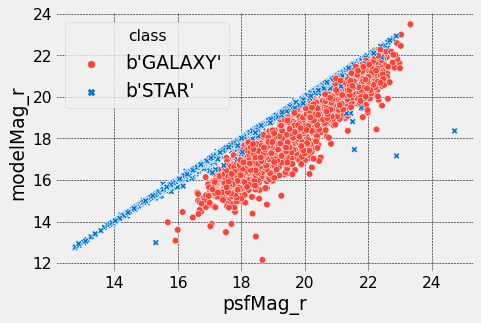

In [75]:
#quick visualization of the data 
fig, ax=plt.subplots(figsize=(6, 4))
sns.scatterplot(x="psfMag_r", y="modelMag_r",
            hue="class", palette=["#FF4136", "#0074D9"], style="class",
            data=SDSSts, ax=ax)

# Random Forest Classifier Example

Let's do some reformatting of the data to allow numerical spectral types \



In [76]:
#some reformatting 
#let's use numerical labels
def numerical_class(c):
  if c==b'GALAXY':
    return 0
  elif c==b'STAR':
    return 1
  else:
    return -1
SDSSts['num_class']=SDSSts['class'].apply(numerical_class)

In [77]:
SDSSts.head(5)

,psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class,num_class
0,18.50914,18.65870,19.34104,17.55135,17.32121,17.58728,17.58728,17.49310,b'GALAXY',0
1,19.03946,19.33727,19.82178,19.07113,19.04754,19.04397,19.04397,19.04397,b'STAR',1
2,19.89376,19.79181,20.47909,19.36626,19.19926,19.36779,19.36779,19.25845,b'GALAXY',0
3,22.04833,22.07411,22.69651,21.53075,21.04837,21.33033,21.33033,21.33033,b'GALAXY',0
4,21.57319,21.57904,22.22763,20.46425,19.93905,20.40421,20.40414,20.20997,b'GALAXY',0


In [78]:
len(SDSSts[SDSSts['num_class']==0]), len(SDSSts[SDSSts['num_class']==1])

(4656, 5344)

Let's split the data into a a training, validation and test set 

This is a critical step in a setting up our machine learning model. 

Splitting the data into smaller these sets allows us to fit the model and evaluate how our machine learning model would perform on unseen/new data. ` sklearn ` has all these tools built in for us, we can just call them directly 

In [79]:
from sklearn.model_selection import train_test_split
RSEED = 42  

#remove 
feats = list(SDSSts.columns)
feats.remove('class')
feats.remove('num_class')

X0 = np.array(SDSSts[feats]) #data
y0 = np.array(SDSSts['num_class']) #labels 

X, X_test, y, y_test = train_test_split(X0,y0,train_size=0.85, random_state=RSEED, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=RSEED, train_size=0.9, shuffle=True)

In [80]:
len(X_train), len(X_val), len(X_test)

(7650, 850, 1500)

In [81]:
y_train, X_train


(array([1, 0, 0, ..., 1, 1, 1]),
 array([[17.80506, 18.16448, 18.64858, ..., 17.82479, 17.8247 , 17.8247 ],
        [19.65141, 19.55112, 20.25477, ..., 18.00459, 17.53884, 17.76034],
        [18.35198, 18.1651 , 18.81612, ..., 17.10813, 16.68579, 16.68579],
        ...,
        [20.31348, 20.66008, 21.14258, ..., 20.28644, 20.28644, 20.28644],
        [17.72037, 18.06293, 18.55004, ..., 17.70456, 17.70224, 17.70224],
        [20.1088 , 20.42461, 20.92325, ..., 20.10264, 20.10322, 20.10319]]))

Let's now build a random forest classifier model directly from Sklearn 

In [82]:
#let's build a random forest classifier 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score

RF = RandomForestClassifier(n_estimators =50)
RF.fit(X_train, y_train) #fitting to the training set 
test_preds = RF.predict(X_test) #predict on the test 

print("The raw features produce a model with accuracy ~{:.4f} !".format(accuracy_score(y_test, test_preds)))

The raw features produce a model with accuracy ~0.9713 !


One can find out which magnitudes here are more important in distinguishing beteen stars and galaxies

In [83]:
RF.feature_importances_ 

array([0.28030336, 0.12436155, 0.16578085, 0.07784307, 0.11587769,
       0.06737792, 0.07311174, 0.09534382])

Text(0.5, 1.0, 'Random Forest Feature Importance ')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


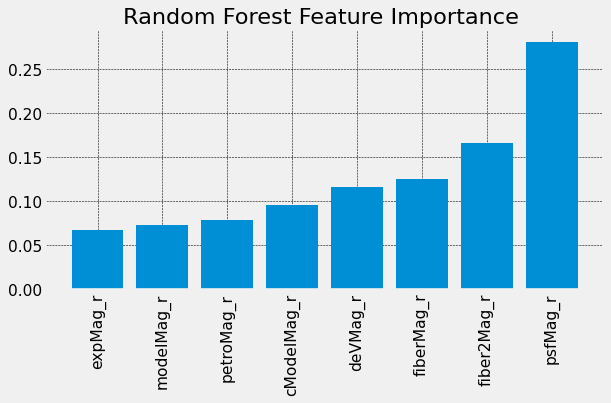

In [84]:
fig, ax=plt.subplots()

tree_feature_importances = (
    RF.feature_importances_)
    
sorted_idx = tree_feature_importances.argsort()

x_ticks = np.arange(0, len(feats))
ax.bar(x_ticks, tree_feature_importances[sorted_idx])
ax.set_xticklabels(np.array(feats)[sorted_idx], rotation='vertical')
ax.set_xticks(x_ticks)
ax.set_title("Random Forest Feature Importance ")

The most important magnitude alone cannot distinguish beteen stars and galaxies since their distributions (stars vs galaxies) overlap

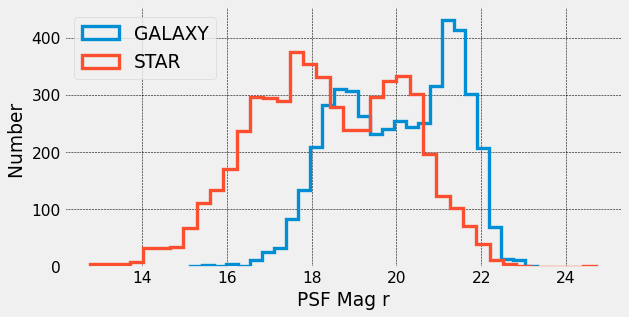

In [85]:
#let's look at the distribution of the most important feature
fig, ax=plt.subplots()
h=plt.hist(SDSSts.psfMag_r[SDSSts.num_class==0], bins='auto',\
           histtype='step', label='GALAXY', lw=3)
h=plt.hist(SDSSts.psfMag_r[SDSSts.num_class==1], bins='auto', \
           histtype='step', label='STAR', lw=3 )
ax.set(xlabel='PSF Mag r', ylabel='Number ')
ax.legend(loc='upper left')
#sure these to 

*How does this model perform in predicting labels for high redshift QSOs?*

Let's select some QSOs to find out,for the purpose of this exericse we are  assuming them to be "like stars" they'd look close to point-sources in images

In [86]:
QSOquery = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'QSO'
             AND s.z > 1.5
             ORDER BY s.specobjid ASC
               """
QSOts = SDSS.query_sql(QSOquery).to_pandas()

qso_X = np.array(QSOts[feats])
qso_y = np.ones(len(QSOts))    # we are defining QSOs as stars for this exercise 

qso_preds = RF.predict(qso_X)

print("The RF model correctly classifies ~{:.4f} of the QSOs".format(accuracy_score(qso_y, qso_preds)))

The RF model correctly classifies ~0.9879 of the QSOs


In [87]:
(qso_y==1).all()

True

Our random forest model can distinguish between stars and galaxies and can classify QSOs as stars at a 98% accuracy !

# Linear Regression 

*Can we predict spectral types of stars from their colors alone?*

Linear regression is fitting data to a line defined by 

$$ y = m x+ b $$ 

For the second part of this exercise, let's move away from SDSS data of galaxies and focus on M dwarfs. Luckily, C. Theissen has collected a dataset of optically classified M dwarfs and their colors in SDSS. Let's compare how a machine learning model will perform vs linear regression. 

For the rest of the notebook, we will be using an "error rate" defined as 

$$ \text{error} = \text{average}( | y- \hat{y}|) $$

where y is the true spectral type and predicted spectral type


In [88]:
import pandas as pd
#read some data (should be a small file)
!wget -O mls_gaia_sdss.csv https://www.dropbox.com/s/07n447jrbs4h2nj/ctheissen_sdss_gaia.csv?dl=0
mls_gaia_sdss=pd.read_csv('mls_gaia_sdss.csv')

--2021-11-19 02:01:48--  https://www.dropbox.com/s/07n447jrbs4h2nj/ctheissen_sdss_gaia.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/07n447jrbs4h2nj/ctheissen_sdss_gaia.csv [following]
--2021-11-19 02:01:48--  https://www.dropbox.com/s/raw/07n447jrbs4h2nj/ctheissen_sdss_gaia.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaa9e28b52bc0559939da73a9e2.dl.dropboxusercontent.com/cd/0/inline/BaNDA-KvD3_43LBdSQXFGegSLpKv76lH9qCCbXLG0gh5qWXvNXYG6t58JYWv8YuH0drJfGq-rdCYzACZWOWfMqxu8NOUxsB6jY0sxb8FQepToCsJnxmR1GPKiAH3lyT3qIC3NbrFQznzZSL-7PwFm3sW/file# [following]
--2021-11-19 02:01:49--  https://ucaa9e28b52bc0559939da73a9e2.dl.dropboxusercontent.com/cd/0/inline/BaNDA-KvD3_43LBdSQXFGegSLpKv76lH9qCCbXLG0gh5qWXvNXYG

In [89]:
mls_gaia_sdss.head(5)

,Unnamed: 0,objid,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,class,subclass
0,0,1237646587712701184,24.84781,23.45551,20.79787,19.16276,17.97528,0.585120,0.200116,0.037273,0.021375,0.028421,STAR,L4
1,1,1237646587713619456,24.21348,22.99118,20.53412,19.38243,18.48108,0.565880,0.140392,0.056177,0.019547,0.030397,STAR,M3
2,2,1237646646230975488,24.88639,22.04076,20.12103,18.72211,17.90512,0.958514,0.080623,0.025404,0.013742,0.023530,STAR,M3
3,3,1237648702966530304,23.19713,19.87924,18.46723,17.16783,16.52462,0.456485,0.028478,0.020112,0.032563,0.014825,STAR,M1
4,4,1237648702966530304,23.19713,19.87924,18.46723,17.16783,16.52462,0.456485,0.028478,0.020112,0.032563,0.014825,STAR,M1


Let's create a numerical type




In [90]:
def type_to_num(st):
  offset=10
  zero_le=st[0]
  if st.startswith('L'):
    offset=20
  if st.startswith('T'):
    offset=30
  return offset+float(st.split(zero_le)[1])

In [91]:
mls_gaia_sdss['num_type']=mls_gaia_sdss.subclass.apply(type_to_num)
#for the purpose of this exercise let's limit ourselves to M stars
mls_gaia_sdss=mls_gaia_sdss[mls_gaia_sdss.num_type < 20 ]


In [92]:
mls_gaia_sdss.head(5)

,Unnamed: 0,objid,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,class,subclass,num_type
1,1,1237646587713619456,24.21348,22.99118,20.53412,19.38243,18.48108,0.565880,0.140392,0.056177,0.019547,0.030397,STAR,M3,13.0
2,2,1237646646230975488,24.88639,22.04076,20.12103,18.72211,17.90512,0.958514,0.080623,0.025404,0.013742,0.023530,STAR,M3,13.0
3,3,1237648702966530304,23.19713,19.87924,18.46723,17.16783,16.52462,0.456485,0.028478,0.020112,0.032563,0.014825,STAR,M1,11.0
4,4,1237648702966530304,23.19713,19.87924,18.46723,17.16783,16.52462,0.456485,0.028478,0.020112,0.032563,0.014825,STAR,M1,11.0
5,5,1237648702966530304,23.19713,19.87924,18.46723,17.16783,16.52462,0.456485,0.028478,0.020112,0.032563,0.014825,STAR,M3,13.0


Let's compute some color combinations and plot them against spectral type


In [93]:
mls_gaia_sdss['r-i']=mls_gaia_sdss.psfmag_r-mls_gaia_sdss.psfmag_i
mls_gaia_sdss['i-z']=mls_gaia_sdss.psfmag_i-mls_gaia_sdss.psfmag_z
mls_gaia_sdss['g-z']=mls_gaia_sdss.psfmag_g-mls_gaia_sdss.psfmag_z
mls_gaia_sdss['u-z']=mls_gaia_sdss.psfmag_u-mls_gaia_sdss.psfmag_z
mls_gaia_sdss['r-z']=mls_gaia_sdss.psfmag_r-mls_gaia_sdss.psfmag_z
mls_gaia_sdss['g-r']=mls_gaia_sdss.psfmag_g-mls_gaia_sdss.psfmag_r
mls_gaia_sdss['g-i']=mls_gaia_sdss.psfmag_g-mls_gaia_sdss.psfmag_i
mls_gaia_sdss['r-u']=mls_gaia_sdss.psfmag_r-mls_gaia_sdss.psfmag_u

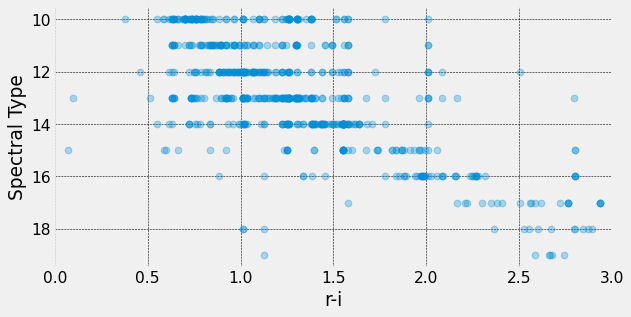

In [94]:
#color spectral type relation
fig, ax=plt.subplots()
ax.errorbar(mls_gaia_sdss['r-i'], \
            mls_gaia_sdss.num_type, fmt='o', alpha=0.3)
ax.set(xlabel='r-i', ylabel='Spectral Type', xlim=[0., 3])
ax.invert_yaxis()

we could fit a line to the data since there seems to be a linear relationship between the colors and spectral types

Let's ignore the uncertainties in the data for now

For this part, we will use the `scipy` library which has this method built in for us. Fill free to code your own linear regression code.


In [95]:
from scipy import  stats
slope, intercept, _, _, _ = stats.linregress(mls_gaia_sdss['r-i'].values, \
                                       mls_gaia_sdss.num_type.values)

In [96]:
slope, intercept

(2.0752976383492157, 10.208595759485636)

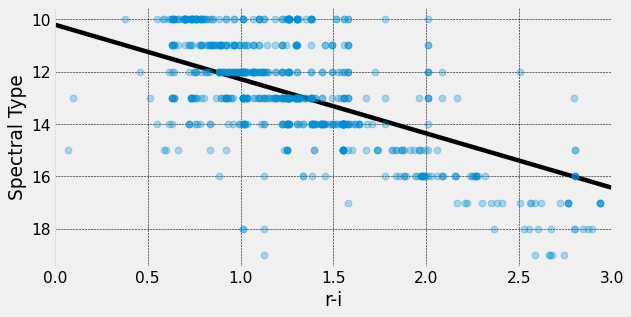

In [97]:
#color spectral type relation
fig, ax=plt.subplots()
ax.errorbar(mls_gaia_sdss['r-i'].values, \
            mls_gaia_sdss.num_type, fmt='o', alpha=0.3)

#let's oveplot a line 
xgrid=np.linspace(0, 3, 20)
ax.plot(xgrid, slope*xgrid+intercept, c='k')
ax.set(xlabel='r-i', ylabel='Spectral Type', xlim=[0., 3])
ax.invert_yaxis()

In [98]:
#compute an average error rate
line_preds=slope*mls_gaia_sdss['r-i'].values+intercept
print ('average error rate {:.4f} subtypes'.format(np.nanmean(abs(line_preds-mls_gaia_sdss.num_type))))

average error rate 1.2777 subtypes


Not too bad for a line!

# Random Forest Regressor

Now we're going to fit a random forest regressor to the r-i colors vs spectral type and compare the results.

For this part of the exercise, we will use `RandomForestRegressor` from `sklearn`

In [99]:
X0=mls_gaia_sdss['r-i'].values.reshape(-1, 1)
y0=mls_gaia_sdss.num_type.values

In [100]:
X, X_test, y, y_test = train_test_split(X0,y0,train_size=0.85, random_state=RSEED, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=RSEED, train_size=0.9, shuffle=True)

In [101]:
RF_reg = RandomForestRegressor(n_estimators = 50)
RF_reg.fit(X_train, y_train)
test_preds = RF_reg.predict(X_test)
print ('average error rate for the RF is {:.4f} subtypes'.format(np.nanmean(abs(test_preds-y_test))))
#this is orse slightly better than the line fit 

average error rate for the RF is 1.1338 subtypes


We can also visualize the predictions of on the test set

Unlike the line fit, there is no "analytical" expression to obtain the prediction 

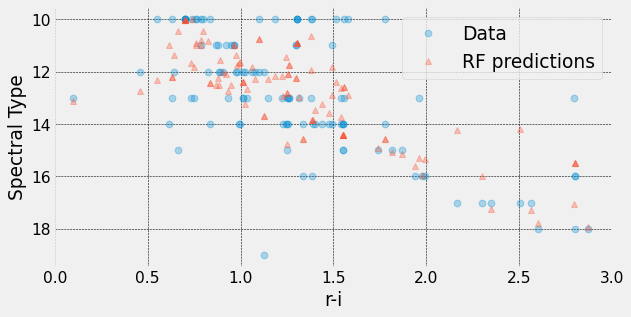

In [102]:
fig, ax=plt.subplots()
ax.errorbar(X_test.flatten(), \
            y_test, fmt='o', alpha=0.3, label='Data')

#let's oveplot RF predictions
ax.errorbar(X_test.flatten(), \
            test_preds, fmt='^', alpha=0.3, label='RF predictions')
ax.set(xlabel='r-i', ylabel='Spectral Type', xlim=[0., 3])
ax.invert_yaxis()
ax.legend()

Challenge: Increase the number of trees (estimators) and compute your error rate

 *what if we used more color-combinations ?*


In [103]:
X0=mls_gaia_sdss[['r-i', 'i-z', 'g-z', 'u-z', 'r-z', 'g-r', 'g-i', 'r-u']].values
y0=mls_gaia_sdss.num_type.values

X, X_test, y, y_test = train_test_split(X0,y0,train_size=0.85, random_state=RSEED, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=RSEED, train_size=0.9, shuffle=True)

In [104]:
RF_reg_more = RandomForestRegressor(n_estimators = 50)
RF_reg_more.fit(X_train, y_train)
test_preds = RF_reg_more.predict(X_test)
print ('average error rate for the RF is {:.4f} subtypes'.format(np.nanmean(abs(test_preds-y_test))))
#this is didn't improve, discuss 

average error rate for the RF is 1.1722 subtypes


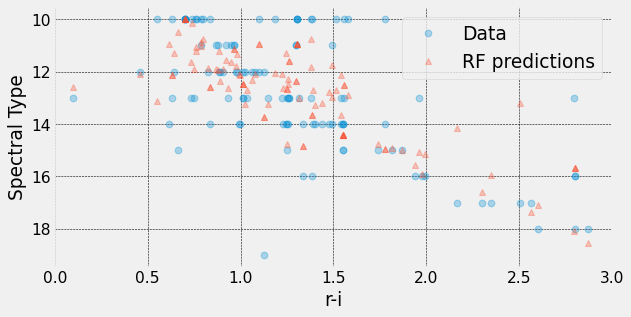

In [105]:
fig, ax=plt.subplots()
ax.errorbar(X_test[:,0], \
            y_test, fmt='o', alpha=0.3, label='Data')

#let's oveplot RF predictions
ax.errorbar(X_test[:,0], \
            test_preds, fmt='^', alpha=0.3, label='RF predictions')
ax.set(xlabel='r-i', ylabel='Spectral Type', xlim=[0., 3])
ax.invert_yaxis()
ax.legend()
#is this an improvement?

*Is this an improvement?*

# Evaluating model & Optimizing Parameters: K-fold Cross- Validation and Grid Search


Let's use the idea of cross-validation to evaluate the performance of this  model on a new dataset 

In [106]:
#manual k-fold cross validation
from numpy import array
from sklearn.model_selection import KFold

In [107]:
def cross_validate(data, labels, k=3):
  """
  This function takes in a model and performs k-fold cross validation 
  Returns the average error rate 
  """
  error=[]
  model= RandomForestRegressor(n_estimators = 50)
  #split the data into 
  kfold = KFold(k, shuffle=True, random_state=RSEED)
  for train_idx, test_idx in tqdm(kfold.split(data)): 
    #train & predict
    model.fit(data[train_idx], labels[train_idx])
    test_preds = model.predict(data[test_idx])
    error.append( np.nanmean(abs(test_preds-labels[test_idx])))

  print( ' Average Model Error  {:.4f} after {} iterations!'.format(np.nanmean(error), k))

In [108]:
cross_validate( X_train, y_train, k=5)
#ok this is the best we can do

5it [00:00,  7.55it/s]

 Average Model Error  1.0827 after 5 iterations!


Let's perform a random search over the number of trees using sklearn functions

In [109]:
from sklearn.model_selection import RandomizedSearchCV

In [110]:
def error_rate(y, ypred):
  return np.nanmean(abs(y-ypred))

Reformat our error function to be digestible by sklearn

In [111]:
from sklearn.metrics import make_scorer
my_scorer = make_scorer(error_rate, greater_is_better=False)

In [112]:
def perform_random_search(X_train, y_train):
  """
  This function perfoms a search over an set of models using cross-validation

  The best function is defined to have the smallest error rate
  """
  #default is 5-fold CV but can be modified
  param_dist = {'n_estimators': np.linspace(20, 500, 10, dtype=int)}            
  random_search = RandomizedSearchCV( RandomForestRegressor(), param_distributions=param_dist, n_jobs=-1, 
                                     verbose=True, random_state=RSEED, scoring=my_scorer )
  random_search.fit(X_train, y_train)
  print ('our best model has {} estimators'.format( random_search.best_estimator_.n_estimators))
  return random_search.best_estimator_


In [113]:
#evaluate our best model
best_model=perform_random_search(X_train, y_train)
best_model.fit(X_train, y_train)
test_preds = best_model.predict(X_test)
print ('average error rate for the RF is {:.4f} subtypes'.format(np.nanmean(abs(test_preds-y_test))))
#discuss the results 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
our best model has 446 estimators
average error rate for the RF is 1.1555 subtypes


Challenge problem: replace  RandomizedSearchCV by GridSearchCV, compare results

In [114]:
features=np.array(['r-i', 'i-z', 'g-z', 'u-z', 'r-z', 'g-r', 'g-i', 'r-u'])

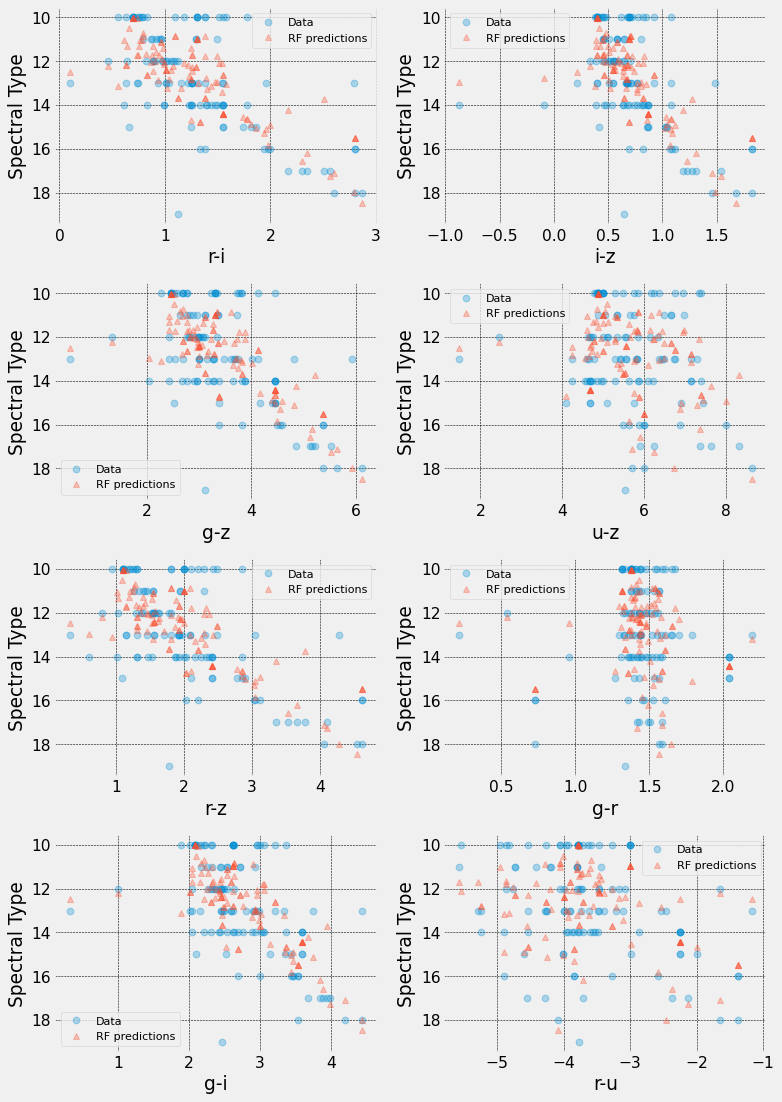

In [115]:
#let's visualize other color-color spaces 
fig, ax=plt.subplots(ncols=2, nrows=4, figsize=(10, 14))
for idx, a in enumerate(np.concatenate(ax)):
  a.errorbar(X_test[:,idx], \
              y_test, fmt='o', alpha=0.3, label='Data')

  #let's oveplot RF predictions
  a.errorbar(X_test[:,idx], \
              test_preds, fmt='^', alpha=0.3, label='RF predictions')
  a.set(xlabel=features[idx], ylabel='Spectral Type')
  a.invert_yaxis()
  a.legend(fontsize=(10))
  plt.tight_layout()
  #is this an improvement?

Text(0.5, 1.0, 'Random Forest Regressor Feature Importance ')

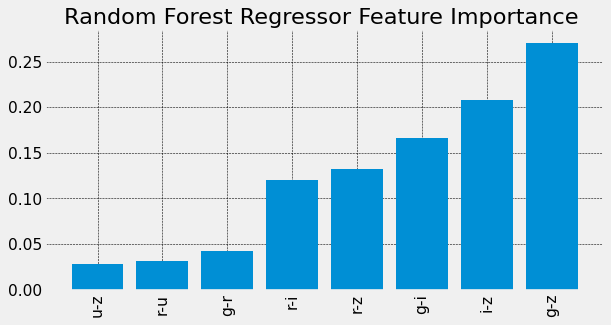

In [116]:
#feature importance, which color best classifies M dwarfs?
fig, ax=plt.subplots()
tree_feature_importances = (
    best_model.feature_importances_)
    
sorted_idx = tree_feature_importances.argsort()

x_ticks = np.arange(0, len(features))
ax.bar(x_ticks, tree_feature_importances[sorted_idx])
ax.set_xticklabels(np.array(features)[sorted_idx], rotation='vertical')
ax.set_xticks(x_ticks)
ax.set_title("Random Forest Regressor Feature Importance ")


# Challenge problem: logistic regression

Challenge, model the spectral type ($y$) given a matrix of colors ($\vec{x}$) as 

$$ y = \sigma (\vec{w} \cdot \vec{x}) $$

and $\vec{w}$  is a weight function which is a parameter to be determined (just like the slope and intercept in the linear regression problem)

 $\sigma$ is a sigmoid function defined as

$$\sigma (z) = \frac{1}{1+ \exp({-z})}$$

This is an "activation function" used in NN nets

Compute the average error rate, how does this compare to the RF and linear regression result ?

You can compute the gradient as 

$$
\frac{\partial{L}}{\partial{w_\alpha}} =  \sum _{t} x_{\alpha, t} y_t-  \sigma (\vec{w} \cdot \vec{x_t})
$$

Implement the gradient descent algorithm



# Simple Neural Network

Compare results to a 5-layer fully-connected neural network 

In this part of the tutorial, we're going to use the keras libray


In [117]:
#import the keras library
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.metrics as k_metrics

In [118]:
#build a simple model
units = 64 #64 nodes of each
learning_rate = 1e-5 #learning rate of 10**-4, try changing it around

heurmodel = keras.Sequential() #this class helps add layers sequentially
heurmodel.add(keras.layers.Activation('sigmoid')) #let's use a sigmoid "activation function for the input"

#add deep layers in sequence
for i in range(1, 6):
  layer=keras.layers.Dense(units=units, activation='sigmoid', input_dim=X.shape[1], use_bias=True, 
                kernel_initializer='GlorotUniform')
  heurmodel.add(layer)
  
#the final prediction should be one
heurmodel.add(Dense(1,activation="linear"))

heurmodel.compile(loss='mean_absolute_error' ,optimizer = keras.optimizers.Adam(learning_rate =learning_rate))

#fit 
model_history= heurmodel.fit(x=X_train, y=y_train,  epochs=4000, 
              shuffle=True, validation_split=0.25, verbose=1, batch_size=70)

Epoch 3988/4000
7/7 [==============================] - 0s 12ms/step - loss: 1.5650 - val_loss: 1.7113
Epoch 3989/4000
7/7 [==============================] - 0s 14ms/step - loss: 1.5650 - val_loss: 1.7113
Epoch 3990/4000
7/7 [==============================] - 0s 12ms/step - loss: 1.5650 - val_loss: 1.7113
Epoch 3991/4000
7/7 [==============================] - 0s 14ms/step - loss: 1.5650 - val_loss: 1.7113
Epoch 3992/4000
7/7 [==============================] - 0s 10ms/step - loss: 1.5650 - val_loss: 1.7113
Epoch 3993/4000
7/7 [==============================] - 0s 13ms/step - loss: 1.5650 - val_loss: 1.7113
Epoch 3994/4000
7/7 [==============================] - 0s 13ms/step - loss: 1.5650 - val_loss: 1.7113
Epoch 3995/4000
7/7 [==============================] - 0s 11ms/step - loss: 1.5651 - val_loss: 1.7113
Epoch 3996/4000
7/7 [==============================] - 0s 11ms/step - loss: 1.5651 - val_loss: 1.7113
Epoch 3997/4000
7/7 [==============================] - 0s 12ms/step - loss: 1.5650

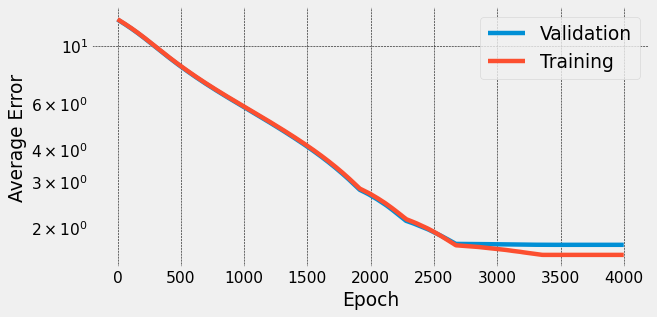

In [121]:
#plot the loss function ("average error")
fig, ax=plt.subplots()
ax.plot(model_history.history['val_loss'], label='Validation')
ax.plot(model_history.history['loss'], label='Training')
ax.set(ylabel='Average Error', xlabel='Epoch', yscale='log')
plt.legend()

Once the validation error flattens and start being larger that our training error, the model is overfitting. One can limit tune the number of training epochs in order to avoid overfitting

In [120]:
#make predictions 
y_pred_neural_net= heurmodel.predict(X_test)
#compute the average error on the test set
print ('average error rate for the RF is {:.4f} subtypes'.format(np.nanmean(abs(y_pred_neural_net-y_test))))

average error rate for the RF is 1.8378 subtypes


Not very good!

You can improve this by defining your a custom loss function and tuning parameters of the neural net

# References & Sources

This notebook uses some material from the LSST-DSFP fellowship program Session 1 shorturl.at/tzMTY , sklearn documentation and astroquery documentation